In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack, ndimage
import math
from tqdm.notebook import tqdm
import seaborn as sns
import galsim

In [7]:
name = 'FRB'
method = 'FFT'
duration = '15s'
num_phot = 1000
it = 104

<Figure size 432x288 with 0 Axes>

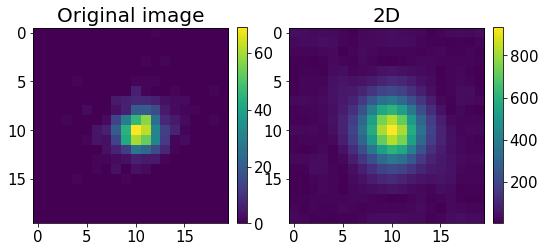

In [8]:
image = np.loadtxt('data/{}s/{}_{}_{}_{}_{}.txt'.format(name, name, method, duration, num_phot, it), delimiter = ',')
image[image < 0] = 0
img = image

#rng = galsim.BaseDeviate()
#gd = galsim.GaussianDeviate(rng, sigma = np.sqrt(1_00))
#gd.add_generate(image)

plt.set_cmap('viridis')
plt.figure(figsize = (13,5))
plt.subplot(1,3,1)
plt.title('Original image', fontsize = 20)
plt.imshow(image)
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
cbar.ax.tick_params(labelsize = 15)
plt.tick_params(labelsize = 15)

fft2 = np.fft.fftshift(np.fft.fft2(image))
ff = np.abs(fft2)
plt.subplot(1,3,2)
plt.title('2D FFT', fontsize = 20)
plt.imshow(ff)
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
cbar.ax.tick_params(labelsize = 15)
plt.tick_params(labelsize = 15)


plt.subplot(1,3,2)
plt.title('2D', fontsize = 20)
plt.imshow(ff)
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
cbar.ax.tick_params(labelsize = 15)
plt.tick_params(labelsize = 15)




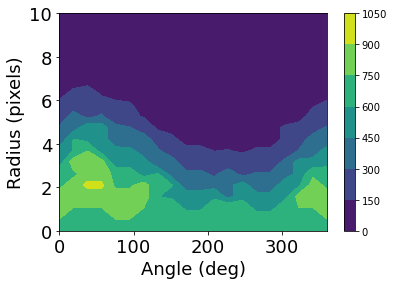

In [9]:
# your code goes here... 

def transform_data(m):
    dpix, dpiy = m.shape
    x_c, y_c = np.unravel_index(np.argmax(m), m.shape)
    angles = np.linspace(0, np.pi*2, min(dpix, dpiy))
    mrc = min(abs(x_c - dpix), abs(y_c - dpiy), x_c, y_c)
    radiuses = np.linspace(0, mrc, max(dpix, dpiy))
    A, R = np.meshgrid(angles, radiuses)
    X = R * np.cos(A)
    Y = R * np.sin(A)
    return A, R, m[X.astype(int) + mrc - 1, Y.astype(int) + mrc - 1]

angles, radiuses, m = transform_data(ff)

plt.contourf(angles*180/np.pi, radiuses, m)
plt.xlabel('Angle (deg)', fontsize = 18)
plt.ylabel('Radius (pixels)', fontsize = 18)
plt.colorbar()
plt.tick_params(labelsize = 18)

In [10]:
print(fft2.shape)

(20, 20)


In [135]:
def crop_normalize(image, length, noise):
    image[image < 0] = 0
    center = np.where(image == np.max(image))
    image = image[center[0][0] - length : center[0][0] + length, center[1][0] - length : center[1][0] + length]
    if noise:
        image = add_noise(image)
    image = image/np.sum(image)
    return image

    
def add_noise(image, level = 1_000):
    image = image + np.random.normal(loc = level, size = (image.shape[0], image.shape[1]))
    
    return image

def angular(name, method, duration, num_phot, it):

    image = np.loadtxt('data/{}s/{}_{}_{}_{}_{}.txt'.format(name, name, method, duration, num_phot, it), delimiter = ',')
    image[image < 0] = 0
    plt.figure(figsize = (13, 4))
    plt.subplot(1,2,1)

    
    image = crop_normalize(image, 6, noise = True)
    image = image/np.sum(image)
    plt.imshow(image)
    plt.tick_params(labelsize = 15)
    plt.xlabel('Pixels', fontsize = 20)
    plt.ylabel('Pixels', fontsize = 20)
    plt.colorbar()
    
    X, Y = np.ogrid[:12, :12]
    center_row, center_col = 5.5, 5.5
    ang_from_center = np.arctan2((X - center_row), -(Y - center_col))
    ang_from_center = (ang_from_center - np.min(ang_from_center))*180/np.pi

    radius = np.unique(ang_from_center)
    angles = np.linspace(0, 360, 10)
    diff = abs(angles[0] - angles[1])

    angular_avg = np.zeros(len(angles))
    for i, ang in enumerate(angles):
        ind = np.where((ang - diff < ang_from_center) & (ang_from_center < ang + diff))
        for ii in range(len(ind[0])):

            angular_avg[i] += image[ind[0][ii], ind[1][ii]]
        #angular_avg[i] /= len(ind[0])
    print(np.mean(angular_avg))
    plt.subplot(1,2,2)
    plt.plot(angles, angular_avg, '-o')
    plt.xlabel('Degrees', fontsize = 20)
    plt.ylabel('Probability', fontsize = 20)
    plt.grid()
    plt.tick_params(labelsize = 15)

0.19934346545248333


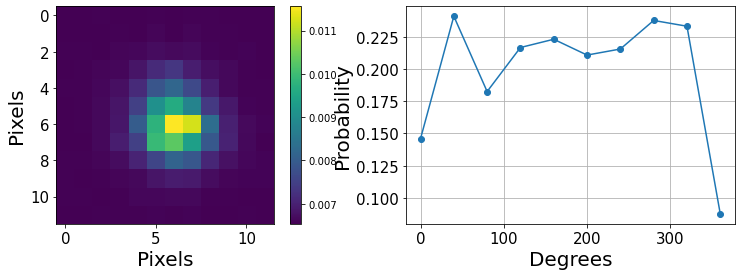

In [140]:
name = 'FRB'
method = 'FFT'
duration = '15ms'
num_phot = 10000
it = 1019
angular(name, method, duration, num_phot, it)


In [20]:
print(ind[0][0])

9


Text(0.5, 1.0, 'Averaged x-axis PSD')

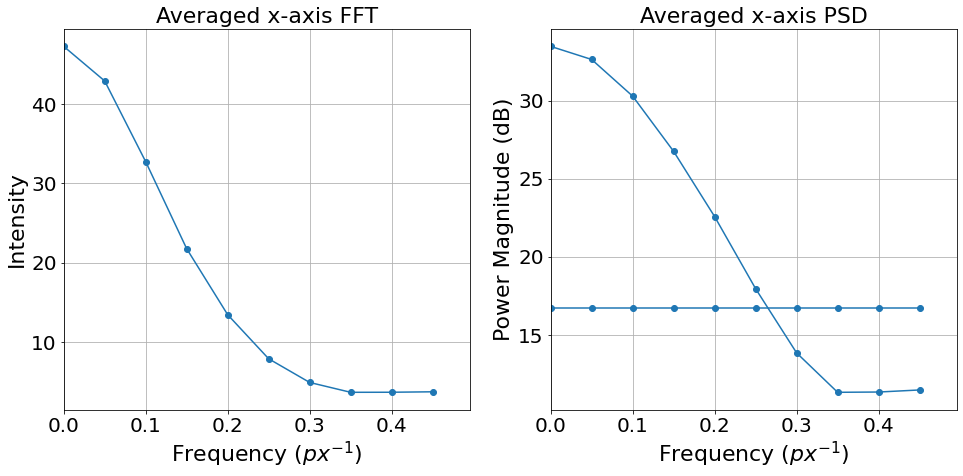

In [69]:
px, py, frequencies = psds(image)
fx, fy, frequencies = ffts(image)

plt.figure(figsize = (16,7))
plt.subplot(1,2,1)
plt.plot(frequencies, fx, 'o-', color = cm.colors[0])

plt.grid()
plt.tick_params(labelsize = 20)
plt.xlabel('Frequency ($px^{-1}$)', fontsize = 22)
plt.ylabel('Intensity', fontsize = 22)
plt.xlim(left = 0)
plt.title('Averaged x-axis FFT', fontsize = 22)

plt.subplot(1,2,2)
plt.plot(frequencies, px, 'o-', color = cm.colors[0])
plt.plot(frequencies, 10*np.log10(np.sum(image)/20)*np.ones(19), 'o-')

plt.grid()
plt.tick_params(labelsize = 20)
plt.xlabel('Frequency ($px^{-1}$)', fontsize = 22)
plt.ylabel('Power Magnitude (dB)', fontsize = 22)
plt.xlim(left = 0)
plt.title('Averaged x-axis PSD', fontsize = 22)

In [12]:
def fft_rad(image):
    
    fft2 = np.fft.fftshift(np.fft.fft2(image))
    ff = np.abs(fft2)
    
    total_rows = 20
    total_cols = 20
    X, Y = np.ogrid[:total_rows, :total_cols]
    center_row, center_col = 9.5, 9.5
    dist_from_center = np.sqrt((X - center_row)**2 + (Y - center_col)**2)

    radius = np.unique(dist_from_center)


    i = 0
    fft_r = np.zeros(len(radius))
    for r in radius:
        ind = np.where(dist_from_center == r)
        for ii in range(len(ind[0])):

            fft_r[i] += ff[ind[0][ii], ind[1][ii]]

        fft_r[i] = 20*np.log10(fft_r[i]/len(ind[0]))
        i += 1
        
    return fft_r, radius
    
def fft_ang(image):
    fft2 = np.fft.fftshift(np.fft.fft2(image))
    ff = np.abs(fft2)
    
    total_rows = 20
    total_cols = 20
    X, Y = np.ogrid[:total_rows, :total_cols]
    center_row, center_col = 9.5, 9.5
    ang_from_center = np.arctan2((X - center_row), -(Y - center_col))
    ang_from_center = (ang_from_center - np.min(ang_from_center))*180/np.pi

    radius = np.unique(ang_from_center)
    angles = np.linspace(0, 360, 18)
    diff = abs(angles[0] - angles[1])

    i = 0
    fft_r = np.zeros(len(angles))
    for r in angles:
        ind = np.where((r - diff < ang_from_center) & (ang_from_center < r + diff))
        for ii in range(len(ind[0])):

            fft_r[i] += ff[ind[0][ii], ind[1][ii]]

        fft_r[i] = fft_r[i]/len(ind[0])
        i += 1

    return fft_r, angles

In [88]:
def ffts(image):
    
    # Round up the size along this axis to an even number
    n = int( math.ceil(image.shape[0] / 2.) * 2 )

    # We use rfft since we are processing real values
    a = np.fft.fftshift(np.fft.fft(image, n, axis = 0))
    psd_x = (np.sum(abs(a), axis = 1)/a.shape[1])

    a = np.fft.fftshift(np.fft.fft(image, n, axis = 1))
    psd_y = (np.sum(abs(a), axis = 0)/a.shape[0])

    # Generate a list of frequencies
    freqs = np.fft.fftshift(np.fft.fftfreq(n))
    
    
    return psd_x[1:], psd_y[1:], freqs[1:]

def psds(image):
    
    # Round up the size along this axis to an even number
    n = int( math.ceil(image.shape[0] / 2.) * 2 )

    # We use rfft since we are processing real values
    a = np.fft.fftshift(np.fft.fft(image, n, axis = 0))
    psd_x = 20*np.log10(np.sum(abs(a), axis = 1)/a.shape[1])
    
    
    a = np.fft.fftshift(np.fft.fft(image, n, axis = 1))
    psd_y = 20*np.log10(np.sum(abs(a), axis = 0)/a.shape[0])

    # Generate a list of frequencies
    freqs = np.fft.fftshift(np.fft.fftfreq(n))
    
    
    return psd_x[1:], psd_y[1:], freqs[1:]

In [89]:
def psd_err(num_sim):
    px = np.zeros((num_sim, 19))
    py = np.zeros((num_sim, 19))
    frequencies = np.zeros(19)

    for it in tqdm(range(0, num_sim)):
        image = np.zeros((20,20))
        rng = galsim.BaseDeviate()
        gd = galsim.GaussianDeviate(rng, sigma = np.sqrt(100_000))
        gd.add_generate(image)
        image = crop_normalize(image, 6, noise = False)
        px[it], py[it], frequencies = psds(image)


    mean_x = np.mean(px, axis = 0)
    var_x = np.var(px, axis = 0)

    mean_y = np.mean(py, axis = 0)
    var_y = np.var(py, axis = 0)
    
    return mean_x, var_x, mean_y, var_y, frequencies

In [25]:
def fft_rad_avg(name, method, duration, num_phot, num_sim):
    px = np.zeros((num_sim, 47))
    py = np.zeros((num_sim, 47))
    noise = np.zeros(num_sim)

    for it in tqdm(range(0, num_sim)):
        image = np.loadtxt('data/{}s/{}_{}_{}_{}_{}.txt'.format(name, name, method, duration, num_phot, it), delimiter = ',')
        image[image < 0] = 0
        rng = galsim.BaseDeviate()
        gd = galsim.GaussianDeviate(rng, sigma = np.sqrt(1_000))
        gd.add_generate(image)
        
        px[it], frequencies = fft_rad(image)
        #noise[it] = 10*np.log10(np.sum(image)/400)


    mean_x = np.mean(px, axis = 0)
    var_x = np.var(px, axis = 0)
    
    return mean_x, var_x, frequencies

def fft_ang_avg(name, method, duration, num_phot, num_sim):
    px = np.zeros((num_sim, 18))
    py = np.zeros((num_sim, 18))
    noise = np.zeros(num_sim)

    for it in tqdm(range(0, num_sim)):
        image = np.loadtxt('data/{}s/{}_{}_{}_{}_{}.txt'.format(name, name, method, duration, num_phot, it), delimiter = ',')
        image[image < 0] = 0
        rng = galsim.BaseDeviate()
        gd = galsim.GaussianDeviate(rng, sigma = np.sqrt(1_000))
        gd.add_generate(image)
        px[it], frequencies = fft_ang(image)
        #noise[it] = 10*np.log10(np.sum(image)/400)


    mean_x = np.mean(px, axis = 0)
    var_x = np.var(px, axis = 0)
    
    return mean_x, var_x, frequencies

In [94]:
def psd_avg(name, method, duration, num_phot, num_sim):
    px = np.zeros((num_sim, 11))
    py = np.zeros((num_sim, 11))
    frequencies = np.zeros(11)
    noise = np.zeros(num_sim)

    for it in tqdm(range(0, num_sim)):
        image = np.loadtxt('data/{}s/{}_{}_{}_{}_{}.txt'.format(name, name, method, duration, num_phot, it), delimiter = ',')
        image[image < 0] = 0
        #rng = galsim.BaseDeviate()
        #gd = galsim.GaussianDeviate(rng, sigma = np.sqrt(100_000))
        #gd.add_generate(image)
        image = crop_normalize(image, 6, noise = False)
        px[it], py[it], frequencies = psds(image)
        noise[it] = 10*np.log10(np.sum(image)/400)


    mean_x = np.mean(px, axis = 0)
    var_x = np.var(px, axis = 0)

    mean_y = np.mean(py, axis = 0)
    var_y = np.var(py, axis = 0)
    
    mean_noise = np.mean(noise)*np.ones(11)
    var_noise = np.var(noise)*np.ones(11)
    
    return mean_x, var_x, mean_y, var_y, mean_noise, var_noise, frequencies

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

(0.0, 14.071424945612296)

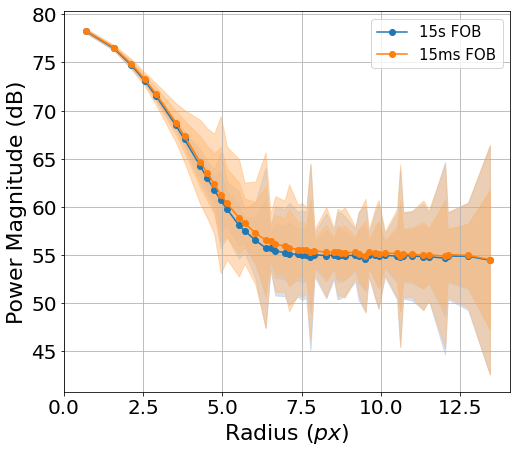

In [26]:
name = 'FRB'
method = 'FFT'
duration = '15s'

plt.figure(figsize = (8,7))
cm = plt.cm.get_cmap('tab20')
num_phot = 10000
mean_x, var_x, frequencies = fft_rad_avg(name, method, '15s', num_phot, 2000)
plt.plot(frequencies, mean_x, 'o-', label='15s FOB', color = cm.colors[0])
plt.fill_between(frequencies, mean_x - 1.65*var_x, mean_x + 1.65*var_x, color = cm.colors[1], alpha=.5)
plt.fill_between(frequencies, mean_x - var_x, mean_x + var_x, color = cm.colors[1], alpha=.5)


num_phot = 10000
mean_x, var_x, frequencies = fft_rad_avg(name, method, '15ms', num_phot, 2000)
plt.plot(frequencies, mean_x, 'o-', label='15ms FOB', color = cm.colors[2])
plt.fill_between(frequencies, mean_x - 1.65*var_x, mean_x + 1.65*var_x, color = cm.colors[3], alpha=.5)
plt.fill_between(frequencies, mean_x - var_x, mean_x + var_x, color = cm.colors[3], alpha=.5)


plt.grid()
plt.tick_params(labelsize = 20)
plt.xlabel('Radius ($px$)', fontsize = 22)
plt.ylabel('Power Magnitude (dB)', fontsize = 22)
plt.legend(fontsize = 15)
plt.xlim(left = 0)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

(0.0, 378.0)

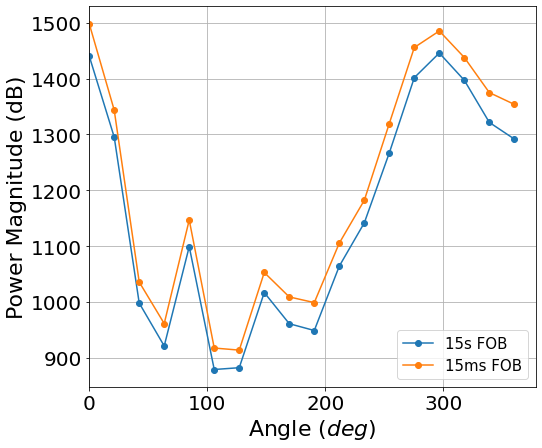

In [28]:
name = 'FRB'
method = 'FFT'
duration = '15s'

plt.figure(figsize = (8,7))
cm = plt.cm.get_cmap('tab20')
num_phot = 10000
mean_x, var_x, frequencies = fft_ang_avg(name, method, '15s', num_phot, 2000)
plt.plot(frequencies, mean_x, 'o-', label='15s FOB', color = cm.colors[0])
#plt.fill_between(frequencies, mean_x - 1.65*var_x, mean_x + 1.65*var_x, color = cm.colors[1], alpha=.5)
#plt.fill_between(frequencies, mean_x - var_x, mean_x + var_x, color = cm.colors[1], alpha=.5)


num_phot = 10000
mean_x, var_x, frequencies = fft_ang_avg(name, method, '15ms', num_phot, 2000)
plt.plot(frequencies, mean_x, 'o-', label='15ms FOB', color = cm.colors[2])
#plt.fill_between(frequencies, mean_x - 1.65*var_x, mean_x + 1.65*var_x, color = cm.colors[3], alpha=.5)
#plt.fill_between(frequencies, mean_x - var_x, mean_x + var_x, color = cm.colors[3], alpha=.5)


plt.grid()
plt.tick_params(labelsize = 20)
plt.xlabel('Angle ($deg$)', fontsize = 22)
plt.ylabel('Power Magnitude (dB)', fontsize = 22)
plt.legend(fontsize = 15)
plt.xlim(left = 0)

  0%|          | 0/2000 [00:00<?, ?it/s]

(0.0, 14.071424945612296)

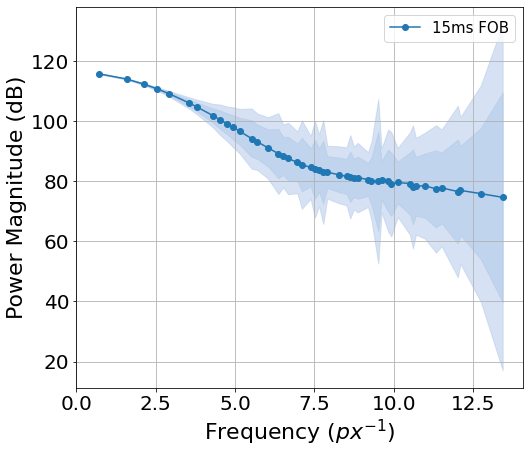

In [53]:
name = 'FRB'
method = 'FFT'
duration = '15ms'

plt.figure(figsize = (8,7))
cm = plt.cm.get_cmap('tab20')
num_phot = 750000
mean_x, var_x, frequencies = fft_rad_avg(name, method, '15ms', num_phot, 2000)
plt.plot(frequencies, mean_x, 'o-', label='15ms FOB', color = cm.colors[0])
plt.fill_between(frequencies, mean_x - 1.65*var_x, mean_x + 1.65*var_x, color = cm.colors[1], alpha=.5)
plt.fill_between(frequencies, mean_x - var_x, mean_x + var_x, color = cm.colors[1], alpha=.5)


plt.grid()
plt.tick_params(labelsize = 20)
plt.xlabel('Frequency ($px^{-1}$)', fontsize = 22)
plt.ylabel('Power Magnitude (dB)', fontsize = 22)
plt.legend(fontsize = 15)
plt.xlim(left = 0)

  0%|          | 0/2000 [00:00<?, ?it/s]

(0.0, 0.4583333333333333)

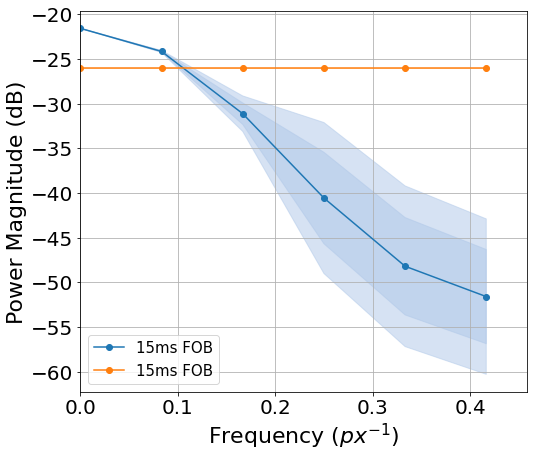

In [97]:
name = 'FRB'
method = 'FFT'
duration = '15ms'

plt.figure(figsize = (8,7))

num_phot = 750000
mean_x, var_x, mean_y, var_y, mean_noise, var_noise, frequencies = psd_avg(name, method, '15ms', num_phot, 2000)
plt.plot(frequencies, mean_x, 'o-', label='15ms FOB', color = cm.colors[0])
plt.fill_between(frequencies, mean_x - 1.65*var_x, mean_x + 1.65*var_x, color = cm.colors[1], alpha=.5)
plt.fill_between(frequencies, mean_x - var_x, mean_x + var_x, color = cm.colors[1], alpha=.5)

plt.plot(frequencies, mean_noise, 'o-', label='15ms FOB', color = cm.colors[2])
plt.fill_between(frequencies, mean_noise - 1.65*var_noise, mean_noise + 1.65*var_noise, color = cm.colors[3], alpha=.5)


plt.grid()
plt.tick_params(labelsize = 20)
plt.xlabel('Frequency ($px^{-1}$)', fontsize = 22)
plt.ylabel('Power Magnitude (dB)', fontsize = 22)
plt.legend(fontsize = 15)
plt.xlim(left = 0)

In [96]:

cm = plt.cm.get_cmap('tab20')

plt.figure(figsize = (8,7))
err_x, err_var_x, err_y, err_var_y, frequencies = psd_err(3000)
plt.plot(frequencies, err_x, 'o-', label='Sky level', color = cm.colors[0])
plt.fill_between(frequencies, err_x - 1.65*err_var_x, err_x + 1.65*err_var_x, color = cm.colors[1])

plt.grid()
plt.tick_params(labelsize = 20)
plt.xlabel('Frequency ($px^{-1}$)', fontsize = 22)
plt.ylabel('Power Magnitude (dB)', fontsize = 22)
plt.title('15ms FOB', fontsize = 22)
plt.legend(fontsize = 15)
plt.xlim(left = 0)

  0%|          | 0/3000 [00:00<?, ?it/s]

ValueError: could not broadcast input array from shape (11,) into shape (19,)

<Figure size 576x504 with 0 Axes>

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

(0.0, 0.4583333333333333)

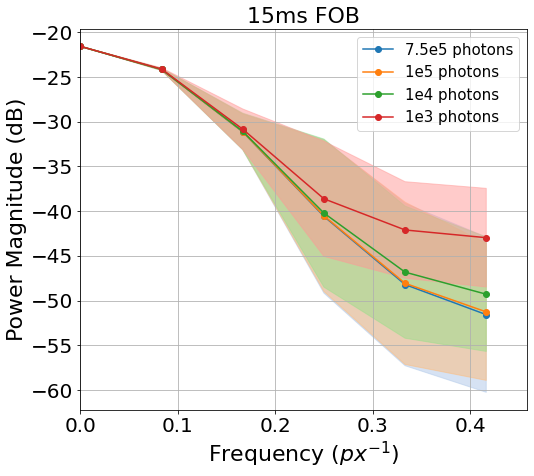

In [101]:
name = 'FRB'
method = 'FFT'
duration = '15ms'

cm = plt.cm.get_cmap('tab20')

plt.figure(figsize = (8,7))

num_phot = 750000
mean_x, var_x, mean_y, var_y, mean_noise, var_noise, frequencies = psd_avg(name, method, duration, num_phot, 3000)
#mean_x = mean_x - err_x
plt.plot(frequencies, mean_x, 'o-', label='7.5e5 photons', color = cm.colors[0])
plt.fill_between(frequencies, mean_x - 1.65*var_x, mean_x + 1.65*var_x, color = cm.colors[1], alpha=.5)

num_phot = 100000
mean_x, var_x, mean_y, var_y, mean_noise, var_noise, frequencies = psd_avg(name, method, duration, num_phot, 2000)
#mean_x = mean_x - err_x
plt.plot(frequencies, mean_x, 'o-', label='1e5 photons', color = cm.colors[2])
plt.fill_between(frequencies, mean_x - 1.65*var_x, mean_x + 1.65*var_x, color = cm.colors[3], alpha=.5)

num_phot = 10000
mean_x, var_x, mean_y, var_y, mean_noise, var_noise, frequencies = psd_avg(name, method, duration, num_phot, 2000)
#mean_x = mean_x - err_x
plt.plot(frequencies, mean_x, 'o-', label='1e4 photons', color = cm.colors[4])
plt.fill_between(frequencies, mean_x - 1.65*var_x, mean_x + 1.65*var_x, color = cm.colors[5], alpha=.5)

num_phot = 1000
mean_x, var_x, mean_y, var_y, mean_noise, var_noise, frequencies = psd_avg(name, method, duration, num_phot, 2000)
#mean_x = mean_x - err_x
plt.plot(frequencies, mean_x, 'o-', label='1e3 photons', color = cm.colors[6])
plt.fill_between(frequencies, mean_x - 1.65*var_x, mean_x + 1.65*var_x, color = cm.colors[7], alpha=.5)


#plt.plot(frequencies, noise_x, 'o-', label='1e3 photons', color = cm.colors[6])
#plt.fill_between(frequencies, mean_x - 1.65*var_x, mean_x + 1.65*var_x, color = cm.colors[7], alpha=.5)

plt.grid()
plt.tick_params(labelsize = 20)
plt.xlabel('Frequency ($px^{-1}$)', fontsize = 22)
plt.ylabel('Power Magnitude (dB)', fontsize = 22)
plt.title('15ms FOB', fontsize = 22)
plt.legend(fontsize = 15)
plt.xlim(left = 0)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

(0.0, 0.495)

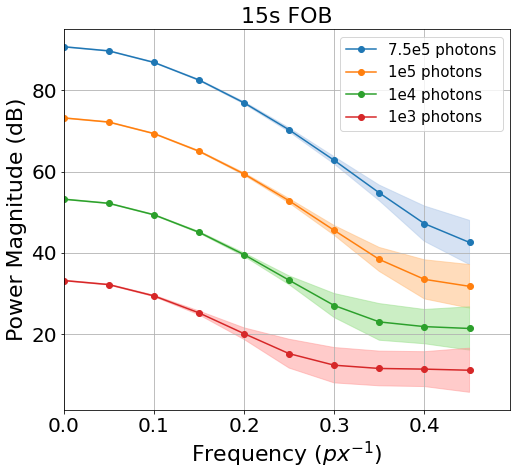

In [39]:
name = 'FRB'
method = 'FFT'
duration = '15s'

cm = plt.cm.get_cmap('tab20')

plt.figure(figsize = (8,7))

num_phot = 750000
mean_x, var_x, mean_y, var_y = psd_avg(name, method, duration, num_phot, 2000)
plt.plot(frequencies, mean_x, 'o-', label='7.5e5 photons', color = cm.colors[0])
plt.fill_between(frequencies, mean_x - 1.65*var_x, mean_x + 1.65*var_x, color = cm.colors[1], alpha=.5)

num_phot = 100000
mean_x, var_x, mean_y, var_y = psd_avg(name, method, duration, num_phot, 2000)
plt.plot(frequencies, mean_x, 'o-', label='1e5 photons', color = cm.colors[2])
plt.fill_between(frequencies, mean_x - 1.65*var_x, mean_x + 1.65*var_x, color = cm.colors[3], alpha=.5)

num_phot = 10000
mean_x, var_x, mean_y, var_y = psd_avg(name, method, duration, num_phot, 2000)
plt.plot(frequencies, mean_x, 'o-', label='1e4 photons', color = cm.colors[4])
plt.fill_between(frequencies, mean_x - 1.65*var_x, mean_x + 1.65*var_x, color = cm.colors[5], alpha=.5)

num_phot = 1000
mean_x, var_x, mean_y, var_y = psd_avg(name, method, duration, num_phot, 2000)
plt.plot(frequencies, mean_x, 'o-', label='1e3 photons', color = cm.colors[6])
plt.fill_between(frequencies, mean_x - 1.65*var_x, mean_x + 1.65*var_x, color = cm.colors[7], alpha=.5)

plt.grid()
plt.tick_params(labelsize = 20)
plt.xlabel('Frequency ($px^{-1}$)', fontsize = 22)
plt.ylabel('Power Magnitude (dB)', fontsize = 22)
plt.title('15s FOB', fontsize = 22)
plt.legend(fontsize = 15)
plt.xlim(left = 0)

In [ ]:
name = 'FRB'
method = 'FFT'
duration = '15s'

cm = plt.cm.get_cmap('tab20')

plt.figure(figsize = (8,7))

num_phot = 1000
mean_x, var_x, mean_y, var_y, mean_noise, var_noise = psd_avg(name, method, '15ms', num_phot, 2000)
plt.plot(frequencies, mean_x, 'o-', label='15ms FOB', color = cm.colors[0])
plt.fill_between(frequencies, mean_x - 1.65*var_x, mean_x + 1.65*var_x, color = cm.colors[1], alpha=.5)
mean_x2 = mean_x

num_phot = 1000
mean_x, var_x, mean_y, var_y, mean_noise, var_noise = psd_avg(name, method, duration, num_phot, 2000)

plt.plot(frequencies, mean_x, 'o-', label='15s FOB', color = cm.colors[6])
plt.fill_between(frequencies, mean_x - 1.65*var_x, mean_x + 1.65*var_x, color = cm.colors[7], alpha=.5)

plt.plot(frequencies, mean_noise, 'o-', label='Noise level', color = cm.colors[8])

plt.grid()
plt.tick_params(labelsize = 20)
plt.xlabel('Frequency ($px^{-1}$)', fontsize = 22)
plt.ylabel('Power Magnitude (dB)', fontsize = 22)
plt.title('{} photons'.format(num_phot), fontsize = 22)
plt.legend(fontsize = 15, title_fontsize = 15)
plt.xlim(left = 0)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [97]:
name = 'FRB'
method = 'FFT'
duration = '15s'

cm = plt.cm.get_cmap('tab20')

plt.figure(figsize = (8,7))

num_phot = 750000
mean_x, var_x, mean_y, var_y = psd_avg(name, method, '15ms', num_phot, 2000)
plt.plot(frequencies, mean_y, 'o-', label='15ms FOB', color = cm.colors[0])
plt.fill_between(frequencies, mean_y - 1.65*var_y, mean_y + 1.65*var_y, color = cm.colors[1], alpha=.5)

num_phot = 750000
mean_x, var_x, mean_y, var_y = psd_avg(name, method, duration, num_phot, 2000)
plt.plot(frequencies, mean_y, 'o-', label='15s FOB', color = cm.colors[6])
plt.fill_between(frequencies, mean_y - 1.65*var_y, mean_y + 1.65*var_y, color = cm.colors[7], alpha=.5)


plt.grid()
plt.tick_params(labelsize = 20)
plt.xlabel('Frequency ($px^{-1}$)', fontsize = 22)
plt.ylabel('Power Magnitude (dB)', fontsize = 22)
plt.legend(fontsize = 15)
plt.xlim(left = 0)

  0%|          | 0/2000 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 4)

<Figure size 576x504 with 0 Axes>

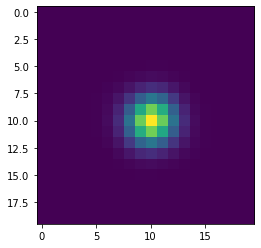

In [39]:
W, H = 20, 20
fft2 = np.fft.fftshift(np.fft.fft2(image))
ff = np.abs(fft2)


plt.imshow(ff)

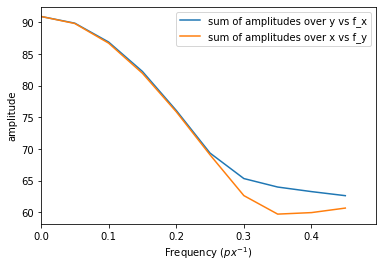

In [5]:

# Round up the size along this axis to an even number
n = int( math.ceil(img.shape[0] / 2.) * 2 )

# We use rfft since we are processing real values
a = np.fft.fftshift(np.fft.fft(img, n, axis=0))

# Sum power along the second axis
a = 20*np.log10(np.sum(abs(a), axis = 1)/a.shape[1])

# Generate a list of frequencies
f = np.fft.fftshift(np.fft.fftfreq(n))

# Graph it
plt.plot(f[1:],a[1:], label = 'sum of amplitudes over y vs f_x')

# Fourier Transform along the second axis

# Same steps as above
n = int( math.ceil(img.shape[1] / 2.) * 2 )

a = np.fft.fftshift(np.fft.fft(img, n, axis = 1))
a = 20*np.log10(np.sum(abs(a), axis = 0)/a.shape[1])

f = np.fft.fftshift(np.fft.fftfreq(n))
plt.plot(f[1:],a[1:],  label ='sum of amplitudes over x vs f_y')

plt.ylabel( 'amplitude' )
plt.xlabel( r'Frequency ($px^{-1}$)' )

plt.xlim(left = 0)

plt.legend()




[-0.5  -0.45 -0.4  -0.35 -0.3  -0.25 -0.2  -0.15 -0.1  -0.05  0.    0.05
  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45]


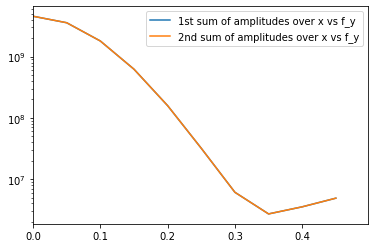

In [43]:
psd_x = np.sum(abs(fft2)**2, axis = 0)/fft2.shape[0]**2
freqs = np.fft.fftshift(np.fft.fftfreq(n))
print(freqs)
plt.semilogy(freqs, psd_x, label ='1st sum of amplitudes over x vs f_y')

plt.xlim(left = 0)
plt.plot(f[1:],a[1:],  label ='2nd sum of amplitudes over x vs f_y')
plt.legend()